In [45]:
! pip install graphviz

In [1]:
! mkdir dataset

In [2]:
cd /dataset

[WinError 3] The system cannot find the path specified: '/content/dataset'
C:\Users\pc\PycharmProjects\DylogT1\CustomCNN


In [3]:
! kaggle datasets download -d emmarex/plantdisease


  0%|          | 0.00/658M [00:00<?, ?B/s]
  0%|          | 1.00M/658M [00:00<03:59, 2.87MB/s]
  0%|          | 2.00M/658M [00:00<02:52, 3.99MB/s]
  0%|          | 3.00M/658M [00:00<02:25, 4.72MB/s]
  1%|          | 4.00M/658M [00:00<01:57, 5.85MB/s]
  1%|          | 5.00M/658M [00:02<06:02, 1.89MB/s]
  1%|          | 6.00M/658M [00:02<04:24, 2.58MB/s]
  1%|1         | 7.00M/658M [00:02<03:34, 3.17MB/s]
  1%|1         | 8.00M/658M [00:02<02:52, 3.95MB/s]
  2%|1         | 10.0M/658M [00:03<02:56, 3.84MB/s]
  2%|1         | 11.0M/658M [00:03<02:34, 4.39MB/s]
  2%|1         | 12.0M/658M [00:03<02:57, 3.81MB/s]
  2%|2         | 14.0M/658M [00:04<03:15, 3.46MB/s]
  2%|2         | 16.0M/658M [00:04<02:19, 4.82MB/s]
  3%|2         | 17.0M/658M [00:05<04:33, 2.46MB/s]
  3%|2         | 19.0M/658M [00:05<03:08, 3.56MB/s]
  3%|3         | 20.0M/658M [00:06<03:29, 3.18MB/s]
  3%|3         | 21.0M/658M [00:06<04:23, 2.54MB/s]
  3%|3         | 23.0M/658M [00:07<02:54, 3.82MB/s]
  4%|3         | 25.

In [4]:
import zipfile
with zipfile.ZipFile('dataset/plantdisease.zip', 'r') as zips:
    zips.extractall('dataset')

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate
from keras.utils import plot_model

In [7]:
dat = 'dataset/PlantVillage'

In [9]:
# PARAMETERS

BATCH_SIZE = 32
IMG_SIZE = (200, 200)
EPOCHS = 10

In [12]:
train_datagen = IDG(
    rescale = 1/.225,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=20,
    height_shift_range=20,
    rotation_range=0.2,
    validation_split=0.3,
#     preprocessing_function=preprocess_input,
    horizontal_flip=True,
)

### THIS BLOICK IS FOR USING A SEPERATE VALIDATION FOLDER ###

# valid_datagen = IDG(
#     rescale = 1/.225,
#     shear_range=0.2,
#     zoom_range=0.2,
#     width_shift_range=20,
#     height_shift_range=20,
#     rotation_range=0.2,
# #     preprocessing_function=preprocess_input,
#     horizontal_flip=True,
# )

train_gen = train_datagen.flow_from_directory(
    dat,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True,
)

valid_gen = train_datagen.flow_from_directory(
    dat,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
)

Found 14452 images belonging to 15 classes.
Found 6186 images belonging to 15 classes.


In [13]:
class_count = len(list(train_gen.class_indices.keys()))
class_count

15

In [34]:
labels = train_gen.class_indices
lab = list(labels)
lab

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [15]:
import os

# Set the directory path
directory_path = dat

names = []

# Iterate through the directories in the path
for dir_name in os.listdir(directory_path):
    if os.path.isdir(os.path.join(directory_path, dir_name)):
        # Print the name of the directory if it is a directory
        names.append(dir_name)
        # print(dir_name)

names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

In [46]:
# function for creating a naive inception block
def naive_inception_module(layer_in, f1, f2, f3):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
	# 5x5 conv
	conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

# define model input
visible = Input(shape=(256, 256, 3))
# add inception module
layer = naive_inception_module(visible, 64, 128, 32)
# create model
model1 = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model1, show_shapes=True, to_file='naive_inception_module.png')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 32)       

In [39]:
model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='valid', input_shape=(200, 200, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(class_count, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 32)       

In [40]:
opt = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [41]:
history = model.fit(train_gen, validation_data = valid_gen, steps_per_epoch = train_gen.samples//BATCH_SIZE, validation_steps = valid_gen.samples//BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/10
451/451 [==============================] - ETA: 0s - loss: 14.0327 - accuracy: 0.1668

KeyboardInterrupt: 

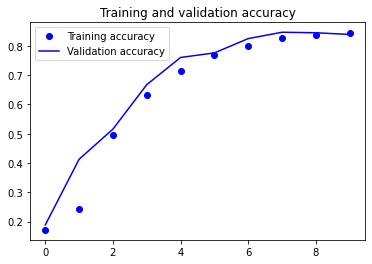

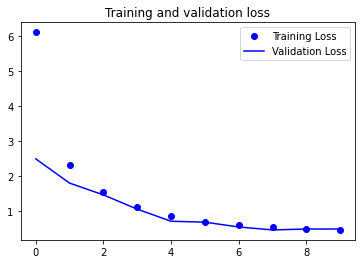

In [23]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
plot_loss_acc(history)

In [67]:
model.save('X1.h5')

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# img = load_image('C:/Users/pc/Downloads/images pot.jpg')

# model = load_model('X1.h5')

def predict(image_path, img_size):
    # Load the image and preprocess it
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
    image = image.astype("float") / 255.0
    image = np.expand_dims(image, axis=0)

    # Make a prediction
    predictions = model.predict(image)

    # Get the predicted class label
    predicted_label = lab[np.argmax(predictions)]

    # Get the predicted class probability
    predicted_prob = np.max(predictions)

    # Return the predicted label and probability
    return predicted_label, predicted_prob

In [38]:
predict('C:/Users/pc/Downloads/images pot.jpg', (200, 200))

1/1 [==============================] - 0s 18ms/step


('Tomato_Late_blight', 0.7679476)